### Reading the data



In [25]:
! python -m pip install scikit-learn --upgrade

Requirement already up-to-date: scikit-learn in d:\python anaconda\lib\site-packages (0.24.2)


In [1]:
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn import tree
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

from tabulate import tabulate

In [2]:
mz_biomass = pd.read_csv("mz_biomass.csv")

In [3]:
## Check descriptive statistics
mz_biomass.describe()

,plot_id,agb,hh,hv,b3,b4,b5,b6,b7
count,606.00000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,303.50000,89.152874,-7.404411,-12.989861,0.054282,0.053498,0.242397,0.201219,0.111524
std,175.08141,62.354027,1.518922,1.846914,0.011230,0.021925,0.031629,0.041874,0.040780
min,1.00000,2.433582,-14.994638,-22.139635,0.026963,0.018775,0.125056,0.096325,0.045125
25%,152.25000,47.311816,-8.311640,-13.975116,0.045903,0.036000,0.221466,0.168911,0.078756
50%,303.50000,74.747372,-7.293537,-12.791153,0.053056,0.049312,0.237084,0.195538,0.103087
75%,454.75000,111.813930,-6.391525,-11.672392,0.060255,0.066905,0.260448,0.225519,0.141477
max,606.00000,444.468299,-3.358704,-8.760588,0.112225,0.148731,0.381375,0.353287,0.253319


In [3]:
y = mz_biomass.agb ## set the response
X = mz_biomass[['hh','hv','b3','b4','b5','b6','b7']] ## set the predictors
## Split into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

### Fitting regression trees


In [4]:
## Specifying the full tree (according to defaults)
dtr_full = DecisionTreeRegressor(random_state=1234)
##
## Fitting the full tree
dtr_full.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1234)

In [5]:
## Predicting to the train and test subsets
y_train_pred_full = dtr_full.predict(X_train)
y_test_pred_full  = dtr_full.predict(X_test)
##
## bias-variance decomposition of the error
dtr_full_train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_full))
dtr_full_train_bias = np.mean(y_train - y_train_pred_full)
dtr_full_train_var  = np.var(y_train - y_train_pred_full)
print(dtr_full_train_rmse, dtr_full_train_bias, dtr_full_train_var)
dtr_full_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_full))
dtr_full_test_bias = np.mean(y_test - y_test_pred_full)
dtr_full_test_var  = np.var(y_test - y_test_pred_full)
print(dtr_full_test_rmse, dtr_full_test_bias, dtr_full_test_var)
##
## Can you comment on the results?
## The full tree perfectly fits the data - overfitting
## BUT when applied to the test subset, the errors are quite high
##
## What's the RMSE in relation to the average ASF value in the test subset?
av_asf_test = np.mean(y_test)

0.0 0.0 0.0
79.71301660997709 -11.750867650747683 6216.082126517099


In [6]:
path = dtr_full.cost_complexity_pruning_path(X_train, y_train)
alpha = path.ccp_alphas


In [7]:
var_train,var_test = [],[]
rmse_train,rmse_test = [],[]
for i in alpha:
    dtr = DecisionTreeRegressor(ccp_alpha=i, random_state=1234)
    dtr.fit(X_train, y_train)
    y_train_pred = dtr.predict(X_train)
    y_test_pred  = dtr.predict(X_test)
    var_train.append(np.var(y_train - y_train_pred)/1000)
    var_test.append(np.var(y_test - y_test_pred)/1000)
    
    rmse_train.append(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    rmse_test.append(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))


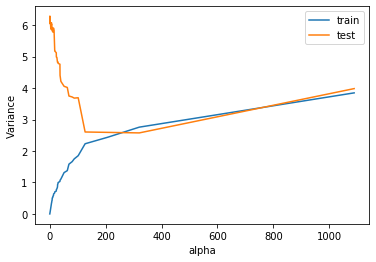

In [8]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Variance")
ax.plot(alpha, var_train, label="train")
ax.plot(alpha, var_test, label="test")

ax.legend()
plt.show()

In [9]:
index_best_model = np.argmin(rmse_test)
alpha_best = alpha[index_best_model]
print(alpha_best)

320.37970157490577


#### Calculating the bias-variance decomposition of the test error


In [29]:
dtr_alpha = DecisionTreeRegressor(ccp_alpha=alpha_best, random_state=1234)
dtr_alpha.fit(X_train, y_train)
y_test_pred_alpha = dtr_alpha.predict(X_test)
dtr_alpha_rmse = "{:.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_alpha)))
dtr_alpha_bias = "{:.4f}".format(np.mean(y_test - y_test_pred_alpha))
dtr_alpha_var  = "{:.4f}".format(np.var(y_test - y_test_pred_alpha))
print(dtr_alpha_rmse, dtr_alpha_bias, dtr_alpha_var)

50.7733 -1.7200 2574.9718


In [28]:
dtr_full_rmse = "{:.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_full)))
dtr_full_bias = "{:.4f}".format(np.mean(y_test - y_test_pred_full))
dtr_full_var  = "{:.4f}".format(np.var(y_test - y_test_pred_full))
print(dtr_full_rmse, dtr_full_bias, dtr_full_var)

79.7130 -11.7509 6216.0821


### Fitting bagging models

In [31]:
esti = [100,200,300,400,500,600,700,800,900,1000]
for i in esti:
    bagg_0 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=i, random_state=1234)
    bagg_0.fit(X_train, y_train)
    bagg_0.pred = bagg_0.predict(X_test)
    bagg_0_rmse = "{:.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, bagg_0.pred)))
    bagg_0_bias = "{:.4f}".format(np.mean(y_test - bagg_0.pred))
    bagg_0_var  = "{:.4f}".format(np.var(y_test - bagg_0.pred))
    print(i,bagg_0_rmse, bagg_0_bias, bagg_0_var)   
# 600 53.4606 -5.9254 2822.9303 with lower rmse,bias,var
bagg_0 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=600, random_state=1234)
bagg_0.fit(X_train, y_train)
bagg_0.pred = bagg_0.predict(X_test)
bagg_0_rmse = "{:.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, bagg_0.pred)))
bagg_0_bias = "{:.4f}".format(np.mean(y_test - bagg_0.pred))
bagg_0_var  = "{:.4f}".format(np.var(y_test - bagg_0.pred))


100 54.2767 -5.9901 2910.0822
200 54.1046 -5.9607 2891.7720
300 54.1037 -6.0966 2890.0445
400 53.7595 -5.9511 2854.6704
500 53.5484 -5.9897 2831.5510
600 53.4606 -5.9254 2822.9303
700 53.6533 -5.9826 2842.8839
800 53.6821 -6.0371 2845.3238
900 53.6511 -5.9445 2843.1025
1000 53.7111 -5.9068 2849.9948


### Fitting boosting models


In [12]:
n_est0,l_rate0,rmse0,bias0,var0 = [],[],[],[],[]
esti = [100,200,300,400,500,600,700,800,900,1000]
lr = [0.001,0.005,0.010,0.050,0.100]
for i in esti:
    for j in lr:
        boost_1 = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=i, learning_rate=j, random_state=1234)
        boost_1.fit(X_train, y_train)
        boost_1.pred = boost_1.predict(X_test)
        boost_1_rmse = "{:.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, boost_1.pred)))
        boost_1_bias = "{:.4f}".format(np.mean(y_test - boost_1.pred))
        boost_1_var  = "{:.4f}".format(np.var(y_test - boost_1.pred))

        n_est0.append(i)
        l_rate0.append(j)
        rmse0.append(boost_1_rmse)
        bias0.append(boost_1_bias)
        var0.append(boost_1_var)
        


In [13]:
dict_error = {'n_est': n_est0, 'l_rate': l_rate0, 'rmse': rmse0, 'bias': bias0,'var': var0}
table_error = pd.DataFrame(data = dict_error)

table_error_sort = table_error.sort_values(by=['rmse'])
print(table_error_sort)

#table_error_sort = table_error.sort_values(by=['bias'])
#print(table_error_sort)
#table_error_sort = table_error.sort_values(by=['var'])
#print(table_error_sort)

print("\nThe best model is:\n", table_error_sort.iloc[0])
# with best rmse and var, bias : 11th place out of 50

    n_est  l_rate     rmse     bias        var
19    400   0.100  54.1026   0.2924  2927.0090
24    500   0.100  54.2658  -0.3444  2944.6559
9     200   0.100  54.3188   0.7251  2950.0081
29    600   0.100  54.3567  -0.4374  2954.4621
4     100   0.100  54.4268   1.0461  2961.1829
44    900   0.100  54.4445   0.1382  2964.1898
14    300   0.100  54.4999   0.6632  2969.8045
16    400   0.005  54.5037   1.9781  2966.7439
21    500   0.005  54.5415   1.6964  2971.8966
26    600   0.005  54.5497   1.6274  2973.0215
11    300   0.005  54.5578   1.9047  2972.9293
39    800   0.100  54.6046  -0.1768  2981.6284
20    500   0.001  54.6567   2.3885  2981.6479
6     200   0.005  54.7304   2.0578  2991.1873
25    600   0.001  54.8286   2.3998  3000.4116
49   1000   0.100  54.8519   0.2341  3008.6801
34    700   0.100  54.8704  -0.5086  3010.4968
1     100   0.005  54.9103   2.5605  3008.5801
31    700   0.005  54.9153   1.5832  3013.1806
10    300   0.001  54.9347   2.9327  3009.2204
33    700   0

### Fitting random forests models

In [14]:
n_est,max_feat,rmse,bias,var = [],[],[],[],[]

for i in [200,400,600,800,1000]:  
    for j in [1,2,3,4,5,6]:  
        rf = RandomForestRegressor(n_estimators=i, max_features=j, random_state=1234)
        rf.fit(X_train, y_train)
        rf.pred = rf.predict(X_test)
        n_est.append(i)
        max_feat.append(j)
        rmse.append("{:.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, rf.pred))))
        bias.append("{:.4f}".format(np.mean(y_test - rf.pred)))
        var.append("{:.4f}".format(np.var(y_test - rf.pred)))

In [15]:
dict_error = {'n_est': n_est, 'max_feat': max_feat, 'rmse': rmse, 'bias': bias,'var': var}

table_error = pd.DataFrame(data = dict_error)
print(table_error)

table_error_sort = table_error.sort_values(by=['rmse'])
print(table_error_sort)
table_error_sort = table_error.sort_values(by=['bias'])
print(table_error_sort)
table_error_sort = table_error.sort_values(by=['var'])
print(table_error_sort)

print("\nThe best model is:\n", table_error_sort.iloc[0])
# with best rmse and var, bias : 5th place out of 30

    n_est  max_feat     rmse     bias        var
0     200         1  51.0318  -5.6126  2572.7441
1     200         2  53.0286  -5.7256  2779.2529
2     200         3  53.4344  -6.4180  2814.0463
3     200         4  53.3200  -5.8683  2808.5819
4     200         5  53.6515  -6.0236  2842.1959
5     200         6  54.0560  -6.4644  2880.2595
6     400         1  51.4783  -5.5093  2619.6638
7     400         2  52.5982  -5.8142  2732.7683
8     400         3  53.4048  -6.1376  2814.3989
9     400         4  53.4107  -6.1243  2815.1946
10    400         5  53.5258  -6.1012  2827.7866
11    400         6  53.5555  -6.2103  2829.6197
12    600         1  51.5546  -5.3655  2629.0902
13    600         2  52.3270  -5.7197  2705.3964
14    600         3  53.0699  -5.8870  2781.7561
15    600         4  53.0915  -5.8510  2784.4766
16    600         5  53.3295  -5.8683  2809.6028
17    600         6  53.4318  -6.1412  2817.2378
18    800         1  51.5330  -5.3871  2626.6294
19    800         2 

In [16]:
## Specify, fit and predict with the best Random Forests model
rf_best = RandomForestRegressor(n_estimators=table_error_sort.n_est[0], 
                                max_features=table_error_sort.max_feat[0], 
                                random_state=1234)
rf_best.fit(X_train, y_train)
rf_best.pred = rf_best.predict(X_test)

In [17]:
## Verify the rmse, bias and variance we got above can be replicated
rf_best_rmse = "{:.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, rf_best.pred)))
rf_best_bias = "{:.4f}".format(np.mean(y_test - rf_best.pred))
rf_best_var  = "{:.4f}".format(np.var(y_test - rf_best.pred))
print('rmse, bias, variance\n', rf_best_rmse, rf_best_bias, rf_best_var)

rmse, bias, variance
 51.0318 -5.6126 2572.7441


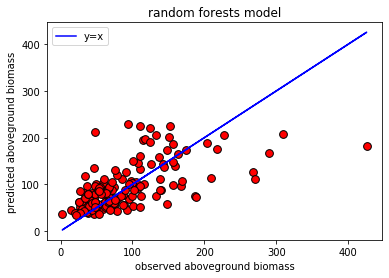

In [33]:
## Plotting the observed vs predicted age of secondary forests
plt.scatter(y_test, rf_best.pred, s=60, edgecolor='black', c='red')
plt.plot(y_test, y_test, c='blue', label='y=x')
plt.title("random forests model")
plt.xlabel("observed aboveground biomass")
plt.ylabel("predicted aboveground biomass")
plt.legend()
plt.show()

### Fitting gradient boosting models

In [19]:
n_est,max_feat,lr_rate,max_dp,rmse,bias,var = [],[],[],[],[],[],[]
for i in [200, 400, 600, 800, 1000]:  ## list with the number of estimators to be tested
    for j in [1, 2, 3, 4, 5, 6]:  ## list with the number of predictors to be tested when splitting a node
        for k in [0.001, 0.005, 0.01, 0.05, 0.1]: ## list with the learning rates
            for l in [3, 5, 7, 9]: ## list of trees maximum depth
                gb = GradientBoostingRegressor(n_estimators=i, 
                                               max_features=j, 
                                               learning_rate=k,
                                               max_depth=l,
                                               random_state=1234)
                gb.fit(X_train, y_train)
                gb.pred = gb.predict(X_test)
                n_est.append(i)
                max_feat.append(j)
                lr_rate.append(k)
                max_dp.append(l)
                rmse.append("{:.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, gb.pred))))
                bias.append("{:.4f}".format(np.mean(y_test - gb.pred)))
                var.append("{:.4f}".format(np.var(y_test - gb.pred)))

In [20]:
dict_error = {'n_est': n_est, 'max_feat': max_feat, 'lr_rate': lr_rate, 'max_dp': max_dp, 'rmse': rmse, 'bias': bias,'var': var}
table_error = pd.DataFrame(data = dict_error)
table_error_sort = table_error.sort_values(by=['bias'])
print(table_error_sort)
#lowest rmse, var, kind of low bias

     n_est  max_feat  lr_rate  max_dp     rmse     bias        var
0      200         1    0.001       3  58.9031  -1.0575  3468.4605
81     200         5    0.001       5  58.3546  -1.0606  3404.1287
100    200         6    0.001       3  58.2305  -1.1017  3389.5801
20     200         2    0.001       3  58.4327  -1.1249  3413.1155
40     200         3    0.001       3  58.2607  -1.1467  3392.9966
102    200         6    0.001       7  58.5533  -1.1488  3427.1682
80     200         5    0.001       3  58.2124  -1.1498  3387.3610
101    200         6    0.001       5  58.2632  -1.1563  3393.2612
82     200         5    0.001       7  58.5626  -1.1590  3428.2395
41     200         3    0.001       5  58.2979  -1.1773  3397.2643
61     200         4    0.001       5  58.2118  -1.2041  3387.1689
60     200         4    0.001       3  58.1973  -1.2045  3385.4773
21     200         2    0.001       5  58.1826  -1.2064  3383.7546
1      200         1    0.001       5  58.3691  -1.2242  3405.

In [21]:
table_error_sort = table_error.sort_values(by=['var'])
print(table_error_sort)

     n_est  max_feat  lr_rate  max_dp     rmse     bias        var
28     200         2    0.010       3  49.8824  -3.8314  2473.5776
124    400         1    0.005       3  49.9346  -3.9118  2478.1601
8      200         1    0.010       3  50.0025  -3.8406  2485.5038
144    400         2    0.005       3  50.1616  -3.9676  2500.4439
68     200         4    0.010       3  50.2894  -3.6573  2515.6482
48     200         3    0.010       3  50.3412  -3.9864  2518.3502
9      200         1    0.010       5  50.4463  -4.0932  2528.0789
184    400         4    0.005       3  50.4555  -3.8252  2531.1247
224    400         6    0.005       3  50.4563  -3.6062  2532.8354
520   1000         3    0.001       3  50.4116  -2.6695  2534.1993
108    200         6    0.010       3  50.4774  -3.5420  2535.4173
24     200         2    0.005       3  50.4492  -2.7541  2537.5386
64     200         4    0.005       3  50.4396  -2.5706  2537.5408
540   1000         4    0.001       3  50.4551  -2.6528  2538.

In [22]:
table_error_sort = table_error.sort_values(by=['rmse'])
print(table_error_sort)
print("The best model is:\n", table_error_sort.iloc[0])

     n_est  max_feat  lr_rate  max_dp     rmse     bias        var
28     200         2    0.010       3  49.8824  -3.8314  2473.5776
124    400         1    0.005       3  49.9346  -3.9118  2478.1601
8      200         1    0.010       3  50.0025  -3.8406  2485.5038
144    400         2    0.005       3  50.1616  -3.9676  2500.4439
68     200         4    0.010       3  50.2894  -3.6573  2515.6482
48     200         3    0.010       3  50.3412  -3.9864  2518.3502
520   1000         3    0.001       3  50.4116  -2.6695  2534.1993
64     200         4    0.005       3  50.4396  -2.5706  2537.5408
9      200         1    0.010       5  50.4463  -4.0932  2528.0789
24     200         2    0.005       3  50.4492  -2.7541  2537.5386
540   1000         4    0.001       3  50.4551  -2.6528  2538.6790
184    400         4    0.005       3  50.4555  -3.8252  2531.1247
224    400         6    0.005       3  50.4563  -3.6062  2532.8354
108    200         6    0.010       3  50.4774  -3.5420  2535.

In [23]:
#gb_best = GradientBoostingRegressor(n_estimators=table_error_sort.n_est[0], 
#                                    max_features=table_error_sort.max_feat[0], 
#                                    learning_rate=table_error_sort.lr_rate[0],
#                                    max_depth=table_error_sort.max_dp[0],
#                                    random_state=1234)

gb_best = GradientBoostingRegressor(n_estimators=200, 
                                    max_features=2, 
                                    learning_rate=0.01,
                                    max_depth=3,
                                    random_state=1234)
gb_best.fit(X_train, y_train)
gb_best.pred = gb_best.predict(X_test)

In [24]:
gb_best_rmse = "{:.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, gb_best.pred)))
gb_best_bias = "{:.4f}".format(np.mean(y_test - gb_best.pred))
gb_best_var  = "{:.4f}".format(np.var(y_test - gb_best.pred))
print('rmse, bias, variance\n', gb_best_rmse, gb_best_bias, gb_best_var)

rmse, bias, variance
 49.8824 -3.8314 2473.5776


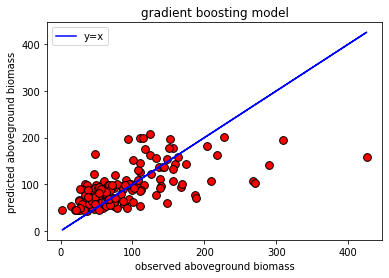

In [34]:
plt.scatter(y_test, gb_best.pred, s=60, edgecolor='black', c='red')
plt.plot(y_test, y_test, c='blue', label='y=x')
plt.title("gradient boosting model")
plt.xlabel("observed aboveground biomass")
plt.ylabel("predicted aboveground biomass")
plt.legend()
plt.show()

### Best model

In [6]:
table_error = [['Algorithm', 'Gradient boosting', 'Random forest'],  ## headers
               ['RMSE', '49.8824', '51.0318'], 
               ['Variance', '2473.5776', '2572.7441'], 
               ['Bias', '-3.8314', '-5.6126'],
               ['No. estimator', '200', '200'],
               ['Learning rate', '0.01', 'N/A'],
               ['Tree depth', '3', 'N/A'],
               ['Max No. of predictors at each node', '2', '1']]
##
## Then, use the tabulate function
print(tabulate(table_error, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════════════════════╤═════════════════════╤═════════════════╕
│ Algorithm                          │   Gradient boosting │ Random forest   │
╞════════════════════════════════════╪═════════════════════╪═════════════════╡
│ RMSE                               │             49.8824 │ 51.0318         │
├────────────────────────────────────┼─────────────────────┼─────────────────┤
│ Variance                           │           2473.58   │ 2572.7441       │
├────────────────────────────────────┼─────────────────────┼─────────────────┤
│ Bias                               │             -3.8314 │ -5.6126         │
├────────────────────────────────────┼─────────────────────┼─────────────────┤
│ No. estimator                      │            200      │ 200             │
├────────────────────────────────────┼─────────────────────┼─────────────────┤
│ Learning rate                      │              0.01   │ N/A             │
├────────────────────────────────────┼──────────────